## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import itertools

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open('/content/drive/MyDrive/Colab Notebooks/Automatic Ticket Classification Assignment/complaints-2021-05-14_08_16.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.

df.head(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [5]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
#Assign new column names
df.rename(columns=lambda x: x.replace('_source.', ''), inplace=True)
df.rename(columns=lambda x: x.strip('_'), inplace=True)

df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
#Create a Copy for Exploratory Data Analysis

df_eda = df.copy(deep=True)
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [8]:
#Assign nan in place of blanks in the complaints column
df_eda['complaint_what_happened'] = np.where(df_eda['complaint_what_happened'] =='', np.nan, df_eda['complaint_what_happened'])
df_eda['complaint_what_happened']

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 78313, dtype: object

In [9]:
cleaned_rows = df_eda['complaint_what_happened'].isna().sum()
ratio = round((cleaned_rows/len(df_eda))*100,2)
print ("{} rows has been cleaned from the original {} rows, which is  {}% of the dataset".format(cleaned_rows, len(df_eda), ratio))

57241 rows has been cleaned from the original 78313 rows, which is  73.09% of the dataset


In [10]:
#Remove all rows where complaints column is nan
df_eda= df_eda[~df_eda.complaint_what_happened.isna()]
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  obj

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [11]:
#Lets first find patterns which we need to remove

brackets = df_eda[df_eda.complaint_what_happened.str.contains('\[\s*\w*\s*\]')]
print("No of complaints with brackets = {}".format(len(brackets)))

No of complaints with brackets = 87


In [12]:
brackets = df_eda[df_eda.complaint_what_happened.str.contains('\S*\d\S*')]
print("No of complaints with words having numbers = {}".format(len(brackets)))

No of complaints with words having numbers = 16494


In [13]:
# Clean the text and remove all the unnecessary elements.
def clean_text(text):
   text = text.lower()
   text = re.sub("\[\s*\w*\s*\]", "", text)
   text = text.translate(str.maketrans('', '', string.punctuation))
   text = re.sub("\S*\d\S*", "", text)

   return text

df_eda.complaint_what_happened = pd.DataFrame(df_eda.complaint_what_happened.apply(lambda x: clean_text(x)))  

In [14]:
pd.set_option('display.max_colwidth', None)
df_eda.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to proc

In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.


In [16]:
#Write your function to Lemmatize the texts
nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])

In [17]:
## Using nlp pipes with chunking for faster execution 
def pos_lemmatize_pipe(doc):
    document_lemma = " ".join([tok.lemma_ for tok in doc])
    document_pos = " ".join([tok.text for tok in doc if tok.pos_ == 'NOUN']) 
    return document_lemma, document_pos

def spacy_pos_lemmatizer(texts):
    return [pos_lemmatize_pipe(doc) for doc in nlp.pipe(texts, batch_size=40, disable=["tok2vec", "parser", "ner"])]
    
df_eda['complaints_lemma'],  df_eda['complaints_pos_tags'] = zip(*spacy_pos_lemmatizer(df_eda.complaint_what_happened))

In [18]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df_eda[['complaint_what_happened', 'complaints_lemma','complaints_pos_tags']].copy()

In [19]:
df_clean.head()

,complaint_what_happened,complaints_lemma,complaints_pos_tags
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember services debt verification statement bank debt mail month debt right information consumer chase account thanks advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,card agent anniversary date agent information order account anniversary date consent xxxx recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent services credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket i come across an offer for to be apply towards the tick

In [20]:
#Write your function to extract the POS tags 



In [21]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaints_lemma,complaints_pos_tags
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember services debt verification statement bank debt mail month debt right information consumer chase account thanks advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,card agent anniversary date agent information order account anniversary date consent xxxx recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent services credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket i come across an offer for to be apply towards the tick

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




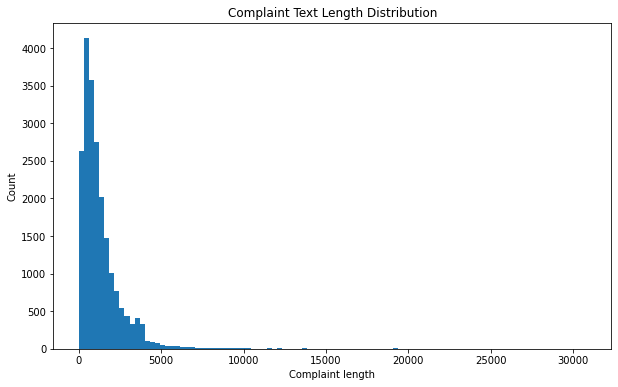

In [22]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_len'] = df_clean['complaint_what_happened'].astype(str).apply(len)

plt.figure(figsize=(10,6))
df_clean['complaint_len'].plot.hist(bins=100, title='Complaint Text Length Distribution')
plt.xlabel('Complaint length')
plt.ylabel('Count')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

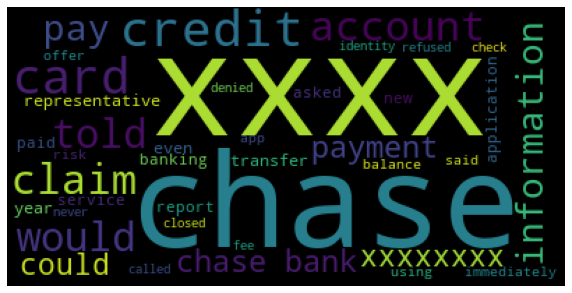

In [23]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
stop_words = set(stopwords.words('english'))

wordcloud = WordCloud(stopwords=stop_words,max_words=40).generate(str(df_clean.complaint_what_happened))

plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [24]:
#Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaints_lemma'].str.replace('-PRON-', '')

In [25]:
#All -PRON- texts has been removed 
df_clean.head()

,complaint_what_happened,complaints_lemma,complaints_pos_tags,complaint_len,complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember services debt verification statement bank debt mail month debt right information consumer chase account thanks advance help,475,good morning name be xxxx xxxx and i appreciate if could help put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what send a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,card agent anniversary date agent information order account anniversary date consent xxxx recording agent,337,i upgrade xxxx xxxx card in and be tell by the agent who do the upgrade anniversary date would not change turn the agent be give the wrong information in order to upgrade the account xxxx change anniversary date from xxxxxxxx to xxxxxxxx without consent xxxx have the recording of the agent who be mislead
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent services credit identity applicant,210,chase card be report on however fraudulent application have be submit identity without consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i a

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [26]:
#Function to return the top 'n' words from corpus for a given 'n_gram_range'
def get_top_n_ngram( corpus, n_gram_range, n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

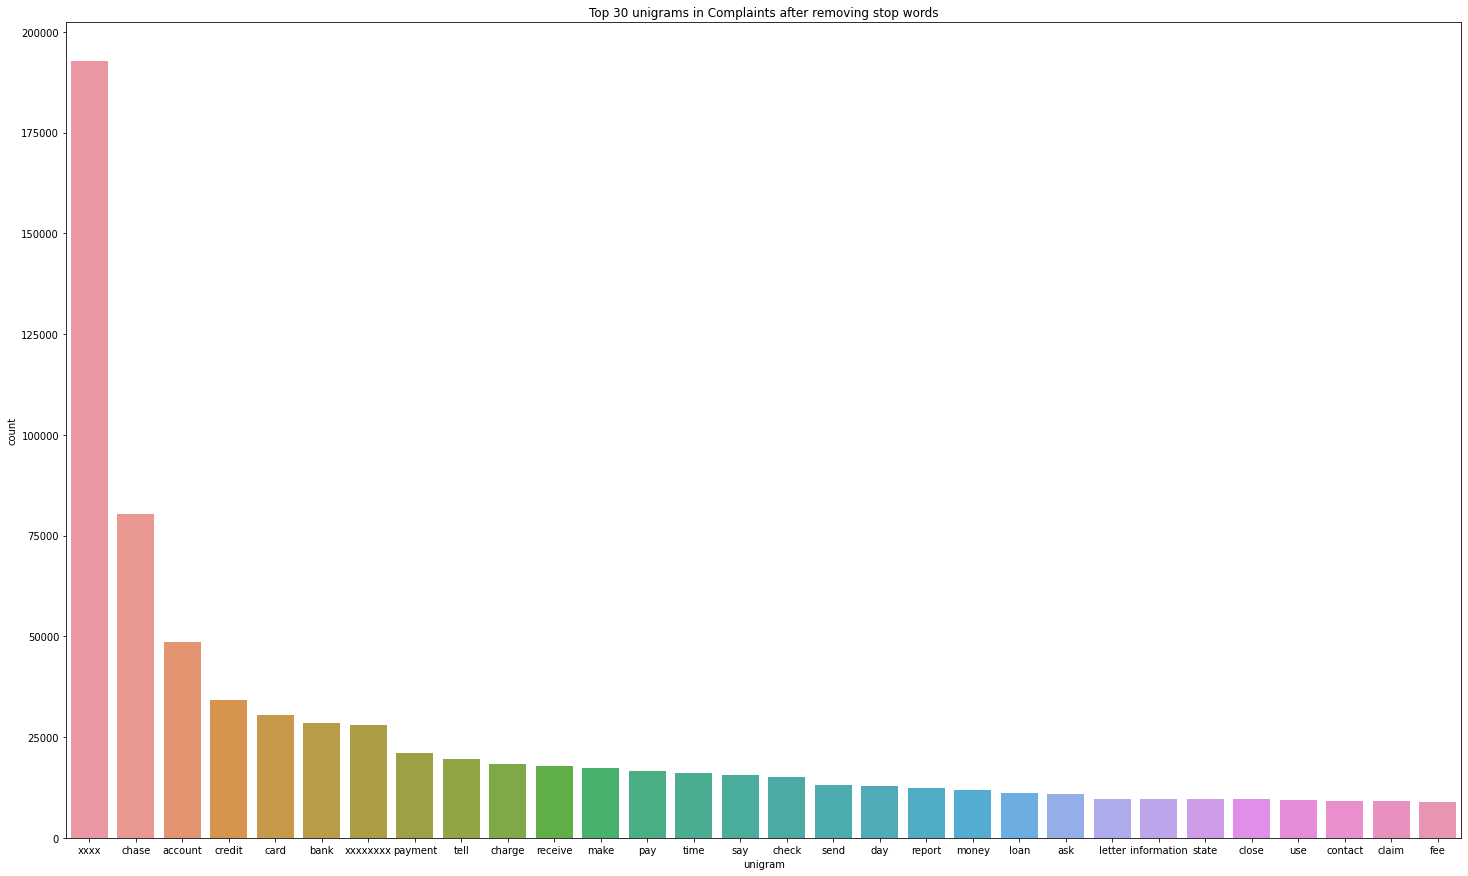

In [27]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = get_top_n_ngram(df_clean.complaint_clean, 1, 30)
df1 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
plt.figure(figsize=[25,15])
fig = sns.barplot(x=df1['unigram'], y=df1['count'])
plt.title('Top 30 unigrams in Complaints after removing stop words')
plt.show()

In [28]:
#Print the top 10 words in the unigram frequency
#The top 10 words in the unigram frequency
df1.head(10)

,unigram,count
0,xxxx,192695
1,chase,80388
2,account,48671
3,credit,34155
4,card,30520
5,bank,28400
6,xxxxxxxx,27927
7,payment,21164
8,tell,19677
9,charge,18230


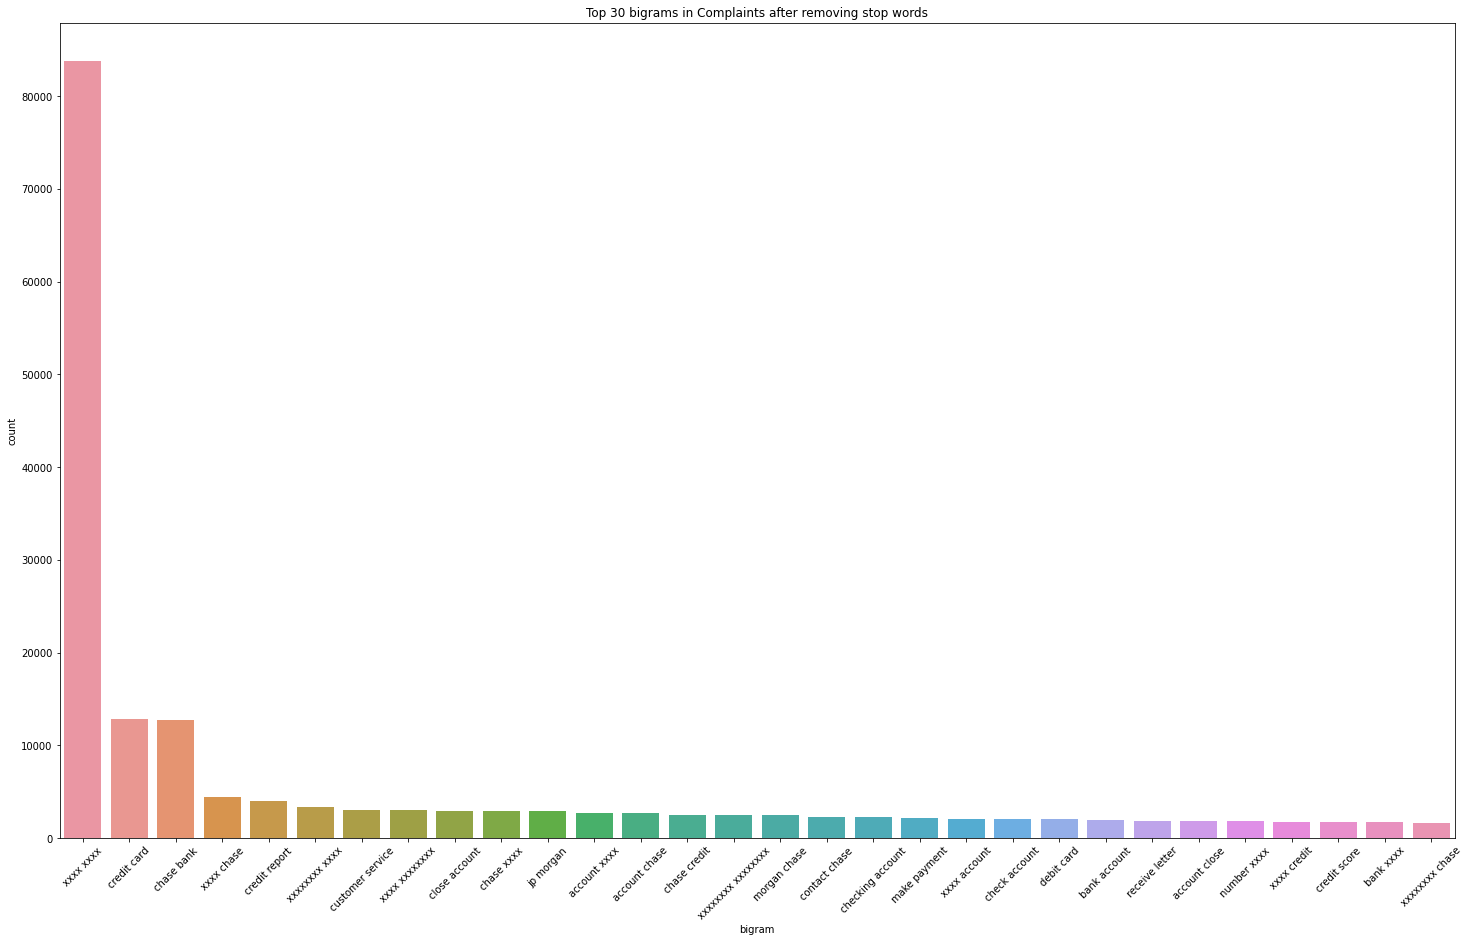

In [29]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = get_top_n_ngram(df_clean.complaint_clean, 2, 30)
df2 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
plt.figure(figsize=[25,15])
plt.xticks(rotation=45)
fig = sns.barplot(x=df2['bigram'], y=df2['count'])
plt.title('Top 30 bigrams in Complaints after removing stop words')
plt.show()

In [30]:
#Print the top 10 words in the bigram frequency
df2.head(10)

,bigram,count
0,xxxx xxxx,83723
1,credit card,12812
2,chase bank,12780
3,xxxx chase,4446
4,credit report,3955
5,xxxxxxxx xxxx,3331
6,customer service,3066
7,xxxx xxxxxxxx,2989
8,close account,2953
9,chase xxxx,2951


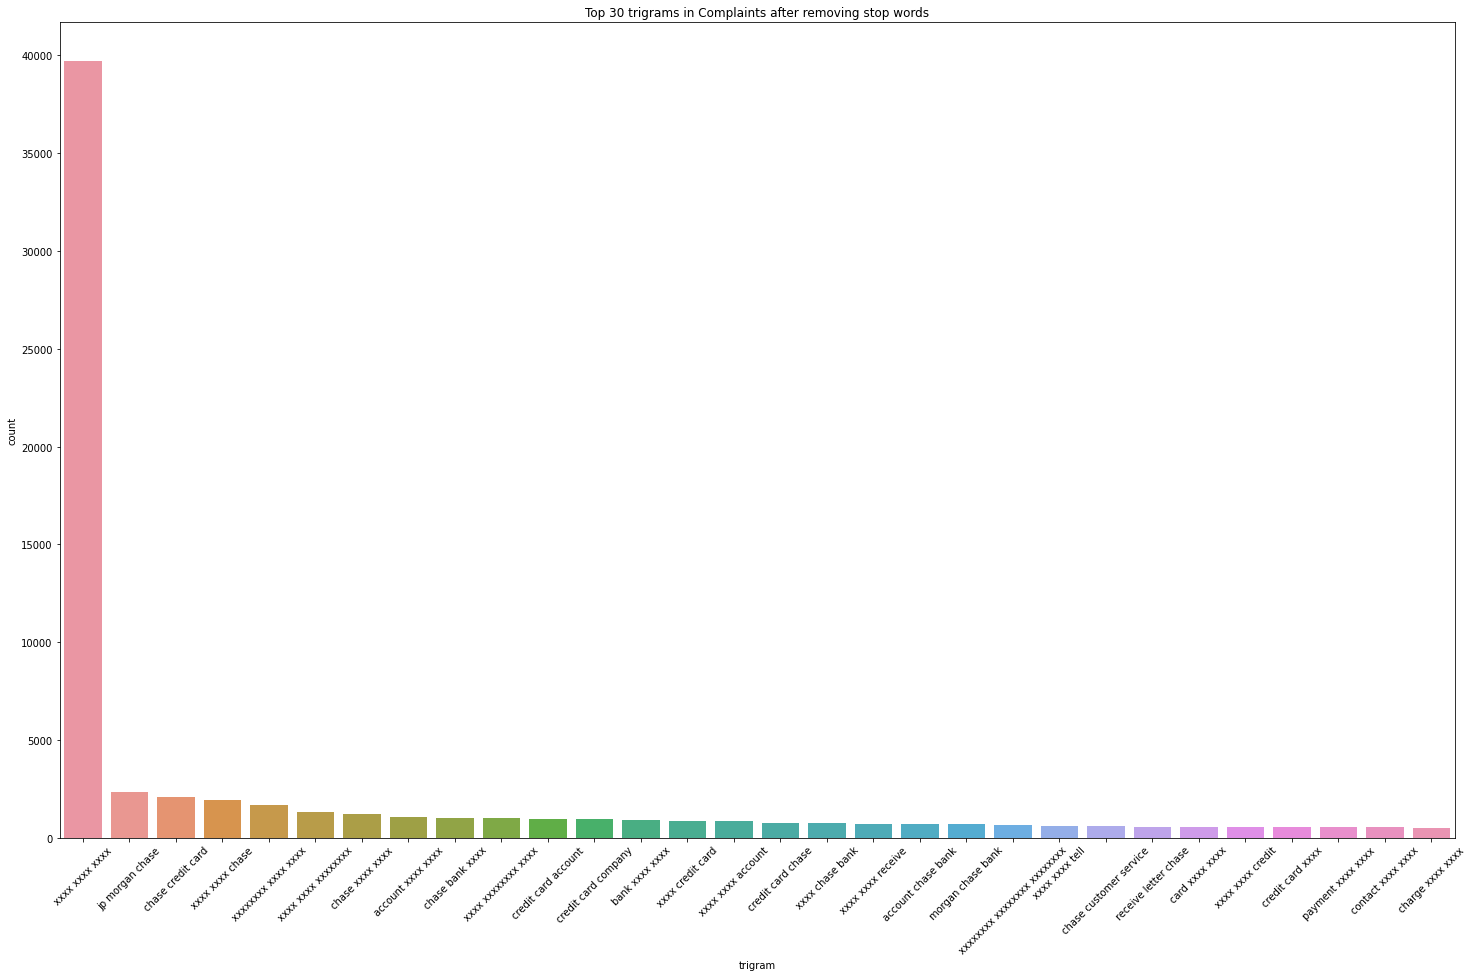

In [31]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = get_top_n_ngram(df_clean.complaint_clean, 3, 30)
df3 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
plt.figure(figsize=[25,15])
plt.xticks(rotation=45)
fig = sns.barplot(x=df3['trigram'], y=df3['count'])
plt.title('Top 30 trigrams in Complaints after removing stop words')
plt.show()

In [32]:
#Print the top 10 words in the trigram frequency
df3.head(10)

,trigram,count
0,xxxx xxxx xxxx,39713
1,jp morgan chase,2349
2,chase credit card,2100
3,xxxx xxxx chase,1903
4,xxxxxxxx xxxx xxxx,1654
5,xxxx xxxx xxxxxxxx,1317
6,chase xxxx xxxx,1187
7,account xxxx xxxx,1052
8,chase bank xxxx,1013
9,xxxx xxxxxxxx xxxx,990


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [33]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')

In [34]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaints_lemma,complaints_pos_tags,complaint_len,complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember services debt verification statement bank debt mail month debt right information consumer chase account thanks advance help,475,good morning name be and i appreciate if could help put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what send a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account thank in advance for help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,card agent anniversary date agent information order account anniversary date consent xxxx recording agent,337,i upgrade card in and be tell by the agent who do the upgrade anniversary date would not change turn the agent be give the wrong information in order to upgrade the account change anniversary date from to without consent have the recording of the agent who be mislead
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent services credit identity applicant,210,chase card be report on however fraudulent application have be submit identity without consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained tha

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [35]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.95)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [36]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.complaint_clean)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [37]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [38]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [39]:
W = nmf_model.fit_transform(dtm)
H = nmf_model.components_
len(tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



11996

In [40]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i}' for i in range(num_topics)],
                columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]
topic_words  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 0,account,check,bank,chase,money,deposit,close,fund,tell,open,branch,say,day,checking,transfer
Topic 1,credit,report,card,inquiry,chase,hard,account,remove,apply,score,company,open,debt,information,close
Topic 2,loan,mortgage,chase,home,modification,property,letter,send,year,request,document,time,foreclosure,rate,bank
Topic 3,charge,card,chase,dispute,transaction,purchase,fee,refund,merchant,claim,receive,fraud,service,use,tell
Topic 4,payment,late,pay,make,balance,fee,month,statement,monthly,day,credit,account,chase,auto,time


#### `Topic 0` looks to be `Bank account services`
#### `Topic 1` looks to be `Credit card / Prepaid card`
#### `Topic 2` looks to be `Mortgages/loans`
#### `Topic 3` looks to be `Theft/Dispute reporting`
#### `Topic 4` looks to be `Others`

In [41]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

colnames = ["Topic {}".format(i) for i in range(nmf_model.n_components)]
complaintnames = ["Complaint{}".format(i) for i in range(len(df_clean.index))]
df_doc_topic = pd.DataFrame(W, columns=colnames, index=complaintnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_clean['topic_id'] = significant_topic

In [42]:
df_doc_topic

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,dominant_topic
Complaint0,0.021636,0.011077,0.037559,0.011166,0.002777,2
Complaint1,0.005409,0.006522,0.005017,0.009831,0.001032,3
Complaint2,0.000000,0.055278,0.003266,0.007794,0.000000,1
Complaint3,0.018323,0.055605,0.026241,0.017528,0.000000,1
Complaint4,0.063368,0.000000,0.003229,0.000000,0.002292,0
...,...,...,...,...,...,...
Complaint21067,0.000000,0.053364,0.000000,0.058610,0.013880,3
Complaint21068,0.008726,0.002484,0.018576,0.047984,0.000000,3
Complaint21069,0.016412,0.013082,0.011732,0.026337,0.000566,3
Complaint21070,0.000000,0.021799,0.004754,0.041571,0.077598,4


In [43]:
# Here we are assigning topic starting from 0, 1,2,3 & 4
W = pd.DataFrame(W, columns=[f'Topic {i}' for i in range(num_topics)], index=[f'Complaint{i}' for i in range(W.shape[0])])
W['max_topic'] = W.apply(lambda x: x.idxmax(), axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,max_topic
Complaint0,0.021636,0.011077,0.037559,0.011166,0.002777,Topic 2
Complaint1,0.005409,0.006522,0.005017,0.009831,0.001032,Topic 3
Complaint2,0.000000,0.055278,0.003266,0.007794,0.000000,Topic 1
Complaint3,0.018323,0.055605,0.026241,0.017528,0.000000,Topic 1
Complaint4,0.063368,0.000000,0.003229,0.000000,0.002292,Topic 0
Complaint5,0.000000,0.072009,0.000000,0.000000,0.000000,Topic 1
Complaint6,0.056977,0.001963,0.009055,0.004615,0.016651,Topic 0
Complaint7,0.001874,0.000496,0.047913,0.009234,0.037389,Topic 2
Complaint8,0.025296,0.000000,0.026435,0.061276,0.000000,Topic 3
Complaint9,0.000000,0.107749,0.000015,0.004174,0.000000,Topic 1


In [44]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W.max_topic.values

In [45]:
df_clean.head()

,complaint_what_happened,complaints_lemma,complaints_pos_tags,complaint_len,complaint_clean,topic_id,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember services debt verification statement bank debt mail month debt right information consumer chase account thanks advance help,475,good morning name be and i appreciate if could help put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what send a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account thank in advance for help,2,Topic 2
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,card agent anniversary date agent information order account anniversary date consent xxxx recording agent,337,i upgrade card in and be tell by the agent who do the upgrade anniversary date would not change turn the agent be give the wrong information in order to upgrade the account change anniversary date from to without consent have the recording of the agent who be mislead,3,Topic 3
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent services credit identity applicant,210,chase card be report on however fraudulent application have be submit identity without consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,1,Topic 1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more informati

In [46]:
#Print the first 5 Complaint for each of the Topics
df_clean_group=df_clean.groupby('Topic').head(5)
df_clean_group.sort_values('Topic')

,complaint_what_happened,complaints_lemma,complaints_pos_tags,complaint_len,complaint_clean,topic_id,Topic
27,i opened an account with chase bank on xxxx and used a code for xxxx bonus i called to follow up on xxxxxxxx about the terms and was told everything was on the account and once i made xxxx direct deposit the bonus would be paid out in days as of xxxx i had made the required deposits and was told my account never had the coupon code applied and it was past the days to do so so no bonus would be paid,i open an account with chase bank on xxxx and use a code for xxxx bonus i call to follow up on xxxxxxxx about the term and be tell everything be on the account and once i make xxxx direct deposit the bonus would be pay out in day as of xxxx i have make the required deposit and be tell -PRON- account never have the coupon code apply and -PRON- be past the day to do so so no bonus would be pay,account code xxxxxxxx terms account deposit bonus days deposits account coupon code days bonus,403,i open an account with chase bank on and use a code for bonus i call to follow up on about the term and be tell everything be on the account and once i make direct deposit the bonus would be pay out in day as of i have make the required deposit and be tell account never have the coupon code apply and be past the day to do so so no bonus would be pay,0,Topic 0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund clear -PRON- chase bank close -PRON- account never pay -PRON- -PRON- money -PRON- say -PRON- need to speek with -PRON- grand son check be clear money be take by -PRON- chase bank refuse to pay -PRON- -PRON- money -PRON- grand son call chase time -PRON- tell -PRON- i should call not -PRON- to verify the check owner -PRON- be out the country most the time date happen check number xxxx claim number be xxxx with chase,son chase account fund bank account money son check money bank money son times check owner country time date check number xxxx claim number,456,grand son give check for i deposit into chase account after fund clear chase bank close account never pay money say need to speek with grand son check be clear money be take by chase bank refuse to pay money grand son call chase time tell i should call not to verify the check owner be out the country most the time date happen check number claim number be with chase,0,Topic 0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional fin

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [47]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    'Topic 0': 'Bank account services',
    'Topic 1': 'Credit card / Prepaid card',
    'Topic 2': 'Mortgages/loans',
    'Topic 3': 'Theft/Dispute reporting',
    'Topic 4': 'Others'   
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [48]:
df_clean.head()

,complaint_what_happened,complaints_lemma,complaints_pos_tags,complaint_len,complaint_clean,topic_id,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember services debt verification statement bank debt mail month debt right information consumer chase account thanks advance help,475,good morning name be and i appreciate if could help put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what send a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account thank in advance for help,2,Mortgages/loans
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,card agent anniversary date agent information order account anniversary date consent xxxx recording agent,337,i upgrade card in and be tell by the agent who do the upgrade anniversary date would not change turn the agent be give the wrong information in order to upgrade the account change anniversary date from to without consent have the recording of the agent who be mislead,3,Theft/Dispute reporting
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent services credit identity applicant,210,chase card be report on however fraudulent application have be submit identity without consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,1,Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she cou

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [49]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [50]:
df_clean

,complaint_what_happened,complaints_lemma,complaints_pos_tags,complaint_len,complaint_clean,topic_id,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember services debt verification statement bank debt mail month debt right information consumer chase account thanks advance help,475,good morning name be and i appreciate if could help put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what send a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account thank in advance for help,2,NaN
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,card agent anniversary date agent information order account anniversary date consent xxxx recording agent,337,i upgrade card in and be tell by the agent who do the upgrade anniversary date would not change turn the agent be give the wrong information in order to upgrade the account change anniversary date from to without consent have the recording of the agent who be mislead,3,NaN
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent services credit identity applicant,210,chase card be report on however fraudulent application have be submit identity without consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,1,NaN
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the

In [51]:
#Keep the columns"complaint_what_happened" & "topic_id" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'topic_id']]

In [52]:
training_data.head()

,complaint_what_happened,topic_id
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,2
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,3
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [53]:
# Split into train, validation 80%,20% respectively
X_train_complaint, X_test_complaint, y_train, y_test = train_test_split(training_data.complaint_what_happened, training_data.topic_id , train_size=0.8, random_state=40)

In [54]:
#Get the Vector count
# We will be doing fit_transform  on train dataset and  transform on the  test data set 
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train_complaint)
X_test = count_vect.transform(X_test_complaint)

#Transform the word vector to tf-idf
# We will be doing fit_transform  on train dataset and  transform on the  test data set 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

In [55]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16857, 30014) (16857,)
(4215, 30014) (4215,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [56]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# This function plots the confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [57]:
## For y_true and y_pred display the Classification Metrics and plot Confusion Matrix
def computeClassificationMetrics(y_test,y_test_pred, plot=True):
        print('*'*20+"Classification Report"+'*'*20)
        print(classification_report(y_test,y_test_pred))
        
        if plot:
            # Compute confusion matrix
            cnf_matrix = confusion_matrix(y_test, y_test_pred)
            print('*'*20+'Confusion Matrix'+'*'*20)
            # Plot non-normalized confusion matrix
            class_names = [0,1,2,3,4]
            plt.figure(figsize=(7,5))
            plot_confusion_matrix(cnf_matrix
                      , classes=class_names)                      
            plt.show()

In [58]:
##Function for training models and testing on a test set. if plot is True, it plots a PRC curve for 
##training and test sets and finds the threshold where (precision*recall) is maximum.
def model_fit(alg, X_train_data, y_train_data, X_test_data, y_test_data, plot=True):
    
    #Fit the algorithm on the data
    alg.fit(X_train_data, y_train_data)
        
    #Predict training set:
    y_train_pred = alg.predict(X_train_data)
    #Predict validation set:
    y_test_pred = alg.predict(X_test_data)
      
    computeClassificationMetrics(y_test_data, y_test_pred, plot)

In [59]:
#Using Decision Trees
dt = DecisionTreeClassifier(max_depth=8, random_state=40)

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.79      0.72      0.75      1001
           1       0.79      0.73      0.76       794
           2       0.61      0.87      0.72       836
           3       0.77      0.67      0.72      1137
           4       0.77      0.68      0.72       447

    accuracy                           0.74      4215
   macro avg       0.75      0.74      0.74      4215
weighted avg       0.75      0.74      0.74      4215

********************Confusion Matrix********************


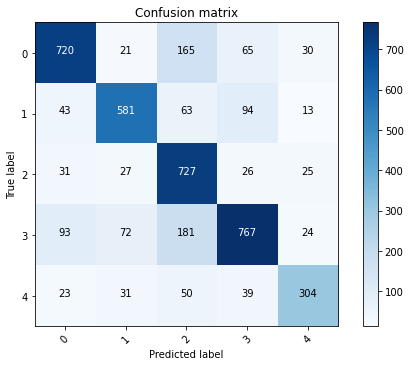

In [60]:
#Model fit on train and validate data
model_fit(dt,X_train, y_train, X_test, y_test ,True)

In [61]:
# Using Random Forest Model :
rfc = RandomForestClassifier(random_state=40)

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1001
           1       0.85      0.83      0.84       794
           2       0.88      0.84      0.86       836
           3       0.80      0.87      0.83      1137
           4       0.93      0.50      0.65       447

    accuracy                           0.83      4215
   macro avg       0.85      0.79      0.81      4215
weighted avg       0.84      0.83      0.83      4215

********************Confusion Matrix********************


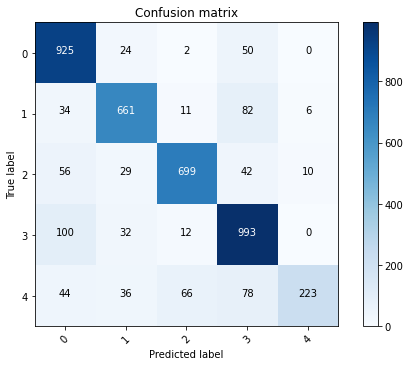

In [62]:
#Model fit on train and validate data
model_fit(rfc,X_train, y_train, X_test, y_test ,True)

In [63]:
# Using multinomial Naive Bayes classifier
mnb = MultinomialNB()

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1001
           1       0.87      0.55      0.67       794
           2       0.83      0.78      0.81       836
           3       0.59      0.94      0.72      1137
           4       1.00      0.03      0.05       447

    accuracy                           0.72      4215
   macro avg       0.82      0.63      0.62      4215
weighted avg       0.78      0.72      0.69      4215

********************Confusion Matrix********************


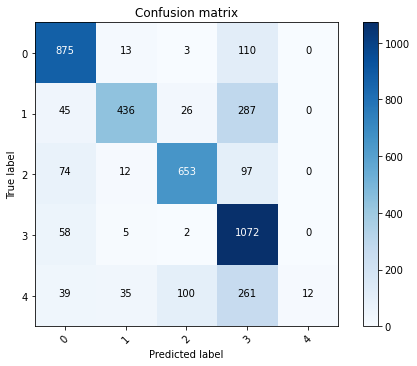

In [64]:
#Model fit on train and test data
model_fit(mnb,X_train, y_train, X_test, y_test ,True)

In [65]:
# Logistic Regression
logreg = LogisticRegression(random_state = 42, max_iter=400)

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1001
           1       0.95      0.93      0.94       794
           2       0.95      0.93      0.94       836
           3       0.93      0.94      0.94      1137
           4       0.97      0.93      0.95       447

    accuracy                           0.94      4215
   macro avg       0.95      0.94      0.94      4215
weighted avg       0.94      0.94      0.94      4215

********************Confusion Matrix********************


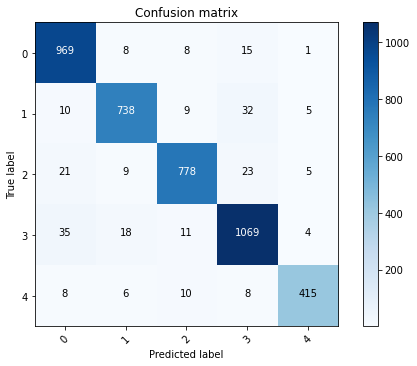

In [66]:
#Model fit on train and test data
model_fit(logreg,X_train, y_train, X_test, y_test ,True)

#### Training Summary ####



| Model | Precision | Recall | F Value | Accuracy | Remarks |
| --- | ----------- | ------ | --------| --------| --------|
| Logistic Regression | 0.94 | 0.94 | 0.94 | 0.94| Baseline Model |
| Decision Tree | 0.75 | 0.74 | 0.74 | 0.74 | Baseline Model | 
| Random Forest | 0.84 |0.83|0.83|0.83 | Baseline Model|
| Naive Bayes | 0.78 |0.72 |0.69 |0.72| Baseline Model|


Based on the above result, we can see that the **Logistic Regression** model gives a good balance between Precision and Recall, and also Accuracy Scores are very good. 

## Model inference

In [67]:
#Custom text to predict the Topic
custom_text = 'I lost my credit card yesterday. I had reported the same immediately. There is delay in the blocking it, please block it immediately'

In [68]:
#Only transform using the existing count_vect
custom_txt_X = count_vect.transform([custom_text])

In [69]:
#Only transform using the existing tfidf_transformer
custom_txt_tfidf = tfidf_transformer.transform(custom_txt_X)

In [70]:
#Predict the topic using logistic regression
y_custom_text_topic_pred = logreg.predict(custom_txt_tfidf)

In [71]:
print(y_custom_text_topic_pred)

[1]


### The model has predicted 1 which is `Credit card or prepaid card`